    AFTER는 지금과 같은 텍스트 블럭 안에 작성되었음

9장: 입력 정보만 사용하는 비지도 학습(Unsupervised Learning)
</br>
</br>
비지도학습 문제: 클러스터링, 차원 압축, 이상 감지 등이 있음
→ 여기서는 클러스터링
</br>
</br>

---

# 9.1 2차원 입력 데이터

**클러스터링**: 클래스 정보 없이, 입력 데이터가 비슷한 것끼리 클래스로 나누는 것</br>
**클러스터**: 데이터의 분포 모양</br>
→ 데이터 분포에서 클러스터를 찾아, 동일한 클러스터에 속하는 데이터 점에는 같은 클래스(라벨)을 붙이고, 다른 클러스터에 속하는 데이터 점에는 다른 클래스를 할당하는 것이 클러스터링
</br>
+ 클래스와 클러스터는 동의어로 사용되는 경우도 있지만 클래스는 단순한 라벨, 클러스터는 분포의 특징을 나타내는 말로 구분됨

**클러스터링의 목적**: 미지의 x에 대한 클래스를 예측하는 것

    AFTER 데이터 분포를 보고 직관적으로 N개의 클러스터로 묶어내고 싶다는 생각이 들 수 있지만 이러한 기준은 연구자의 직관에 의존하고 있어서 임의적이라는 한계를 가짐.
    따라서 아래와 같은 클러스터링 기법들을 활용하면 임의성의 문제를 극복하고 샘플들을 일관적이고 합리적인 방식으로 묶어낼 수 있음!

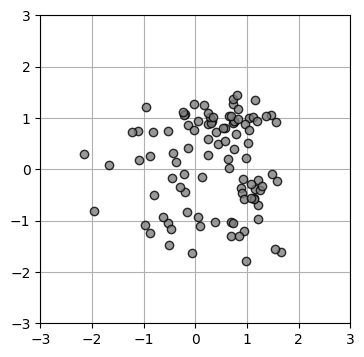

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 생성 ------------------
np.random.seed(1)
N = 100
K = 3
T3 = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
X_col = ['cornflowerblue', 'black', 'white']
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 누적 확률
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):
        X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k]
                   + Mu[T3[n, :] == 1, k])

# 데이터를 그리기 ------------------
def show_data(x):
    plt.plot(x[:, 0], x[:, 1], linestyle='none',
             marker='o', markersize=6,
             markeredgecolor='black', color='gray', alpha=0.8)
    plt.grid(True)

# 메인 ----------------------------
plt.figure(1, figsize=(4, 4))
show_data(X)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()
### 나중에 다시 사용할 수 있도록 데이터 저장
np.savez('data_ch9.npz', X=X, X_range0=X_range0,
         X_range1=X_range1)

# 9.2 K-means 기법


### 9.2.1 K-means 기법의 개요

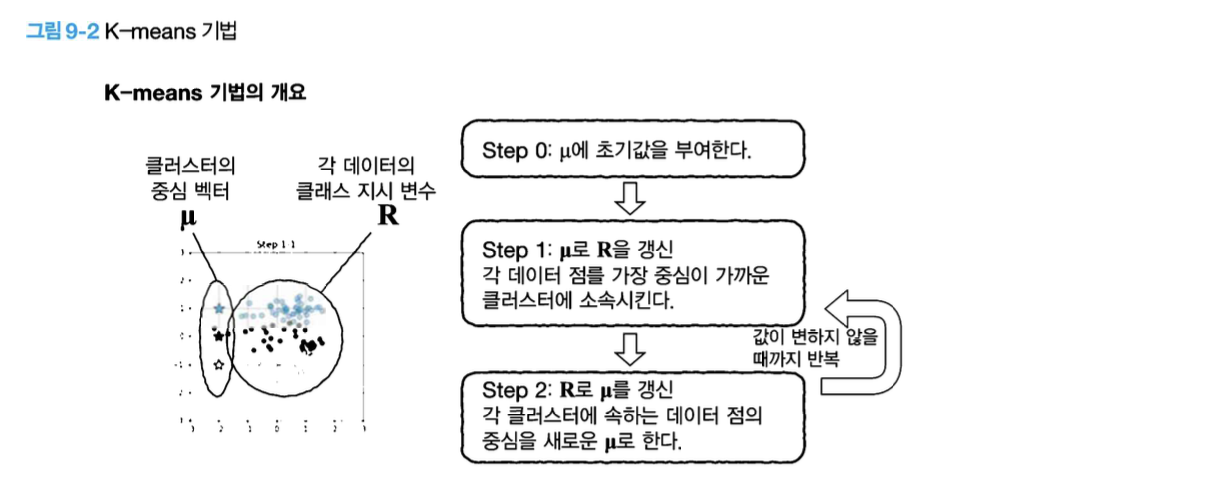

미리 분할할 클러스터의 수 K를 정해야함: 여기서는 K=3 </br>
K-means 기법에서는 변수 두 개가 필요함
- μ : 클러스터의 중심 벡터
- R : 각 데이터의 클래스 지시 변수
    - 각 데이터 점이 어떤 클러스터에 속하는지를 나타냄

- Step 0을 통해 클러스터의 중심이 잠정적으로 결정됨

### 9.2.2 Step 0: 변수의 준비와 초기화

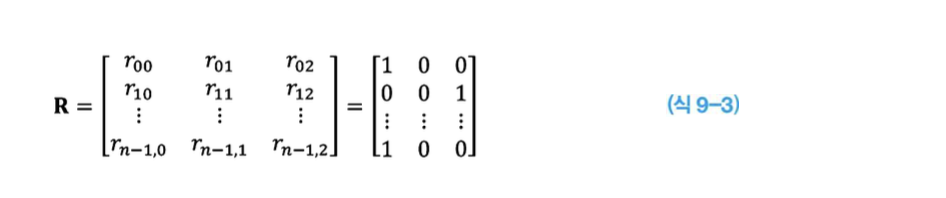
---

- 입력이 2차원 → 클러스터 중심도 2차원 벡터
- 클래스 지시 변수 R: 데이터가 어느 클래스에 속해 있는지를 1-of-K 부호화법으로 나타낸 행렬
    - rnk = 1 데이터 n이 k에 속하는 경우
    - rnk = 0 데이터 n이 k에 속하지 않는 경우

In [ ]:
# Mu 및 R 초기화 ---------------------
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]]) # (A)
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)] # (B)

(B)에서 모든 데이터가 클래스 0에 속하도록 R을 초기화 했지만, R은 Mu로 결정되기 때문에 어떻게 초기화하든 결과에 영향 없음

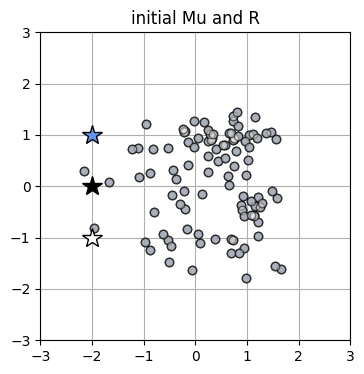

In [ ]:
# 데이터를 그리는 함수 ---------------
def show_prm(x, r, mu, col):
    for k in range(K):
        # 데이터 분포의 묘사
        plt.plot(x[r[:, k] == 1, 0], x[r[:, k] == 1, 1],
                 marker='o',
                 markerfacecolor=X_col[k], markeredgecolor='k',
                 markersize=6, alpha=0.5, linestyle='none')
        # 데이터의 평균을 '별표'로 묘사
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=X_col[k], markersize=15,
                 markeredgecolor='k', markeredgewidth=1)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    plt.grid(True)


# ---------------------------------
plt.figure(figsize=(4, 4))
R = np.c_[np.ones((N, 1)), np.ones((N, 2))]
show_prm(X, R, Mu, X_col)
plt.title('initial Mu and R')
plt.show()

### 9.2.3 Step 1: R의 갱신

R의 갱신 방법: 각 데이터 점을 가장 중심이 가까운 클러스터에 넣는다

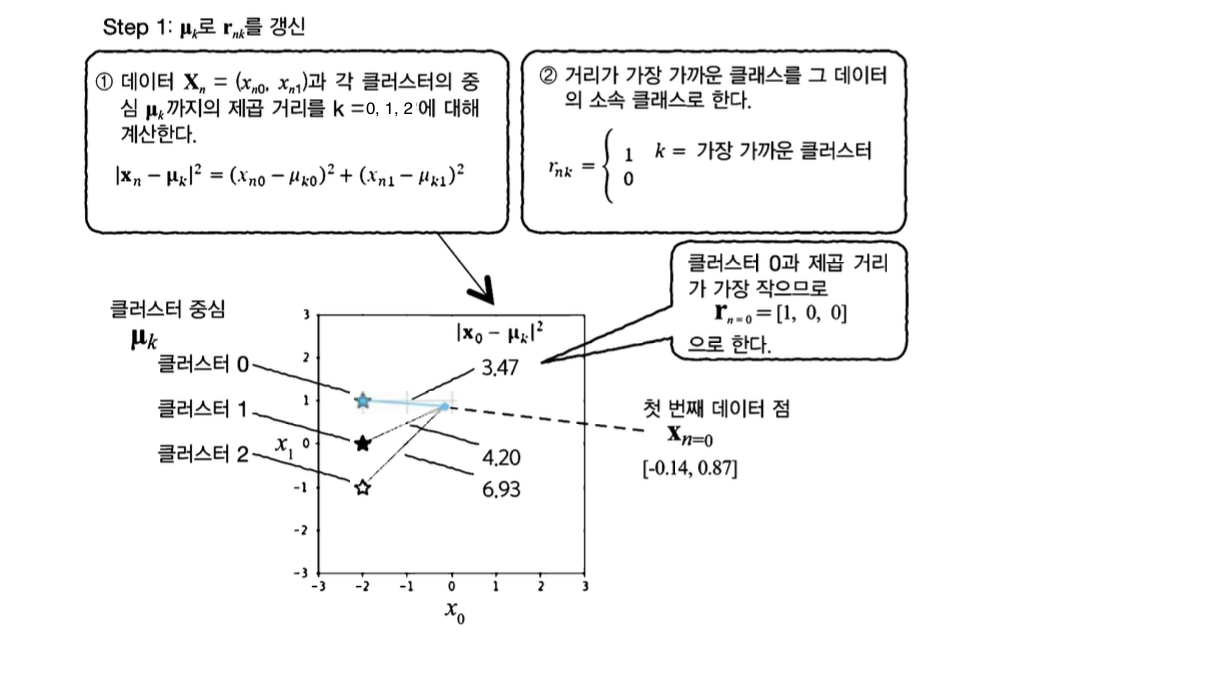

- 지금은 거리 자체를 알고 싶은 것이 아니라 데이터 점에서 가장 가까운 클러스터를 알면 좋기 때문에, 제곱근의 계산을 생략한 제곱 거리를 비교하여 가장 가까운 클러스터를 결정

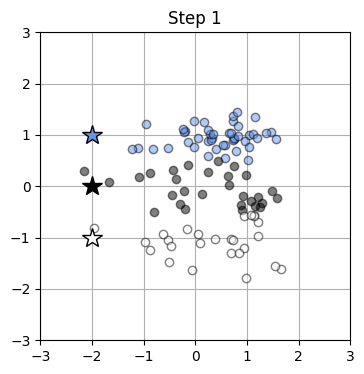

In [ ]:
# r을 정한다 (step 1) -------------
def step1_kmeans(x0, x1, mu):
    N = len(x0)
    r = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = (x0[n] - mu[k, 0])**2 + (x1[n] - mu[k, 1])**2
        r[n, np.argmin(wk)] = 1
    return r

# --------------------------------
plt.figure(figsize=(4, 4))
R = step1_kmeans(X[:, 0], X[:, 1], Mu)
show_prm(X, R, Mu, X_col)
plt.title('Step 1')
plt.show()

### 9.2.4 Step 2: μ의 갱신

μ의 갱신 방법: 각 클러스터에 속하는 데이터 점의 중심을 새로운 μ로 한다
- k=0에 속하는 데이터 점에 주목해 각 평균을 구함

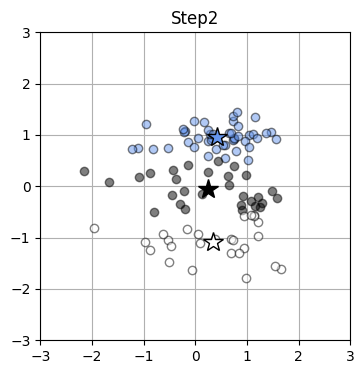

In [ ]:
# Mu 결정 (Step 2) --------------------
def step2_kmeans(x0, x1, r):
    mu = np.zeros((K, 2))
    for k in range(K):
        mu[k, 0] = np.sum(r[:, k] * x0) / np.sum(r[:, k])
        mu[k, 1] = np.sum(r[:, k] * x1) / np.sum(r[:, k])
    return mu


# -------------------------------------
plt.figure(figsize=(4, 4))
Mu = step2_kmeans(X[:, 0], X[:, 1], R)
show_prm(X, R, Mu, X_col)
plt.title('Step2')
plt.show()

μk가 각각의 분포 중심으로 이동한 것 확인 가능

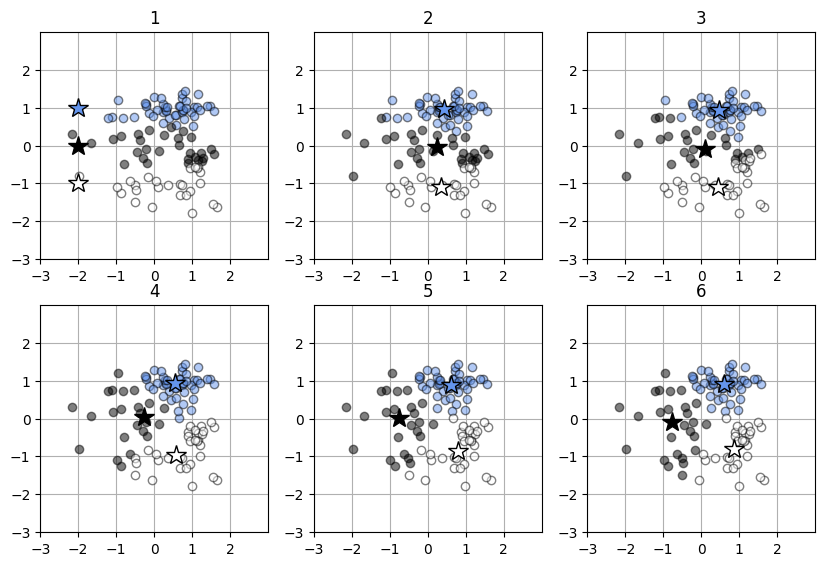

In [ ]:
### Step 1과 2의 절차를 반복 후 변수의 값이 변하지 않으면 프로그램 종료
plt.figure(1, figsize=(10, 6.5))
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
max_it = 6 # 반복 횟수
for it in range(0, max_it):
    plt.subplot(2, 3, it+1)
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    show_prm(X, R, Mu, X_col)
    plt.title("{0:d}".format(it+1))
    plt.xticks(range(X_range0[0], X_range0[1]))
    plt.yticks(range(X_range1[0], X_range1[1]))
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
plt.show()

### 9.2.5 왜곡 척도

**왜곡 척도**: 목적함수에 대응하는 것으로, 데이터 점이 속한 클러스터의 중심까지의 제곱 거리를 전체 데이터로 합한 것

In [ ]:
# 목적 함수 ------------------
def distortion_measure(x0, x1, r, mu):
    # 입력은 2차원으로 제한하고 있다
    N = len(x0)
    J = 0
    for n in range(N):
        for k in range(K):
            J = J + r[n, k] * ((x0[n] - mu[k, 0])**2
                               + (x1[n] - mu[k, 1])**2)
    return J


# test ----------------------
# Mu와 R의 초기화
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
dm = distortion_measure(X[:, 0], X[:, 1], R, Mu)
print("초기값의 왜곡 척도: ", dm)

초기값의 왜곡 척도:  771.7091170334878


[627.54  73.39  70.39  57.59  48.31  47.28  46.86  46.86  46.86  46.86]


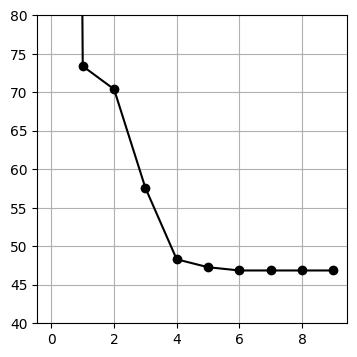

In [ ]:
# Mu와 R의 초기화
N = X.shape[0]
K = 3
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
max_it = 10
it = 0
DM = np.zeros(max_it) # 왜곡 척도의 계산 결과를 넣는다
for it in range(0, max_it): # K-means 기법
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    DM[it] = distortion_measure(X[:, 0], X[:, 1], R, Mu) # 왜곡 척도
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
print(np.round(DM, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(DM, color='black', linestyle='-', marker='o')
plt.ylim(40, 80)
plt.grid(True)
plt.show()

- step을 진행할수록 왜곡 척도는 점차 감소하고 step6에서 값이 46.86으로 수렴하는 모습을 보임 (μ와 R의 값이 변화하지 않음)

K-means 기법으로 얻을 수 있는 해는 _초기값 의존성_ 이 있음</br>
: 처음 μ에 무엇을 할당하는지에 따라 결과가 달라질 수 있음</br>
→ 다양한 μ에서 시작하여 얻은 결과 중 가장 왜곡 척도가 작은 결과를 사용

# 9.3 가우시안 혼합 모델
- 이름 그대로 가우시안 분포가 여러 개 혼합된 클러스터링 알고리즘
- 자연적인 현상을 표현하기에 좋은 모델: 데이터마이닝, 패턴 인식, 통계 분석 등에 광범위하게 사용됨

### 9.3.1 확률적 클러스터링

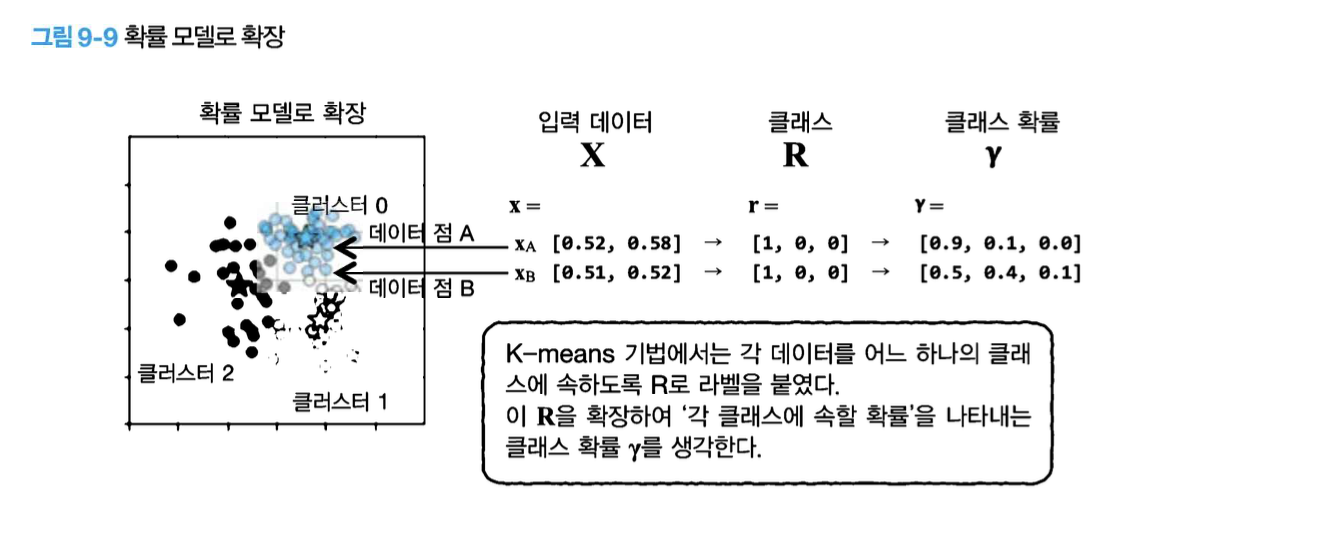

γ: 데이터가 각 클래스에 속할 확률
→ 어떤 쪽의 클러스터에는 반드시 속하므로 모든 확률을 더하면 1이 됨

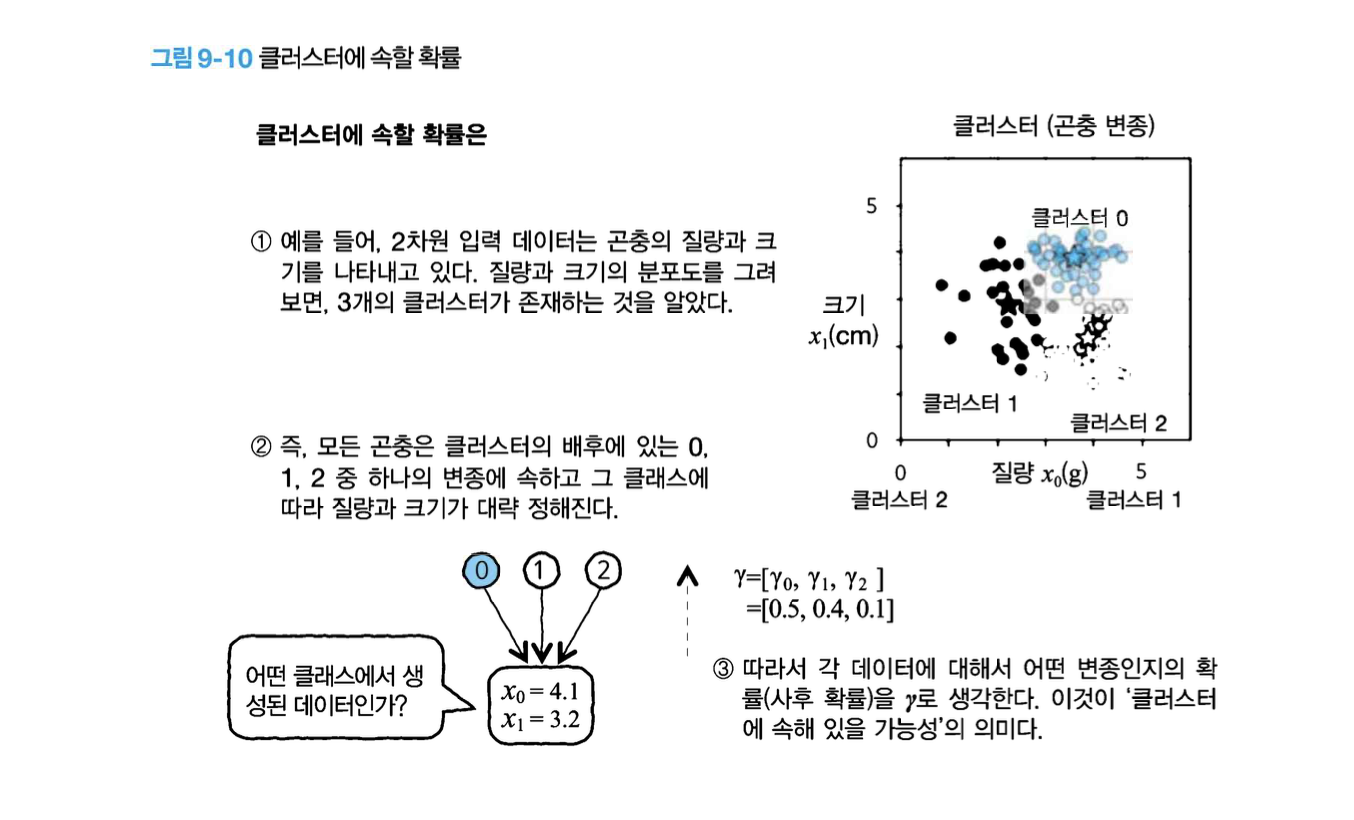

잠재 변수 Z (숨은 변수Hidden variable)
- 관찰은 못했지만 데이터에 영향을 준 변수
- 구성개념이 직접적으로 관찰되거나 측정이 되지 않는 변수

**γnk**
- 데이터 n이 클러스터 k에 속할 확률
- 데이터 xn인 곤충이 클래스 k의 변종일 확률

</br>
→ 관찰할 수 없는 Z의 추정치가 γ

- Z는 어떤 클래스에 속하고 있는가, 이므로 0 또는 1의 값을 가짐
- γ는 확률적인 추정 값으로 0에서 1의 실수 값을 취함
    - 부담률 γ: 어떤 클러스터에 얼마나 기여하고 있는가

➡️ **확률적 클러스터링** 데이터의 배후에 숨어 있는 잠재 변수 Z를 확률적으로 γ로 추정하는 것



### 9.3.2 가우시안 혼합 모델

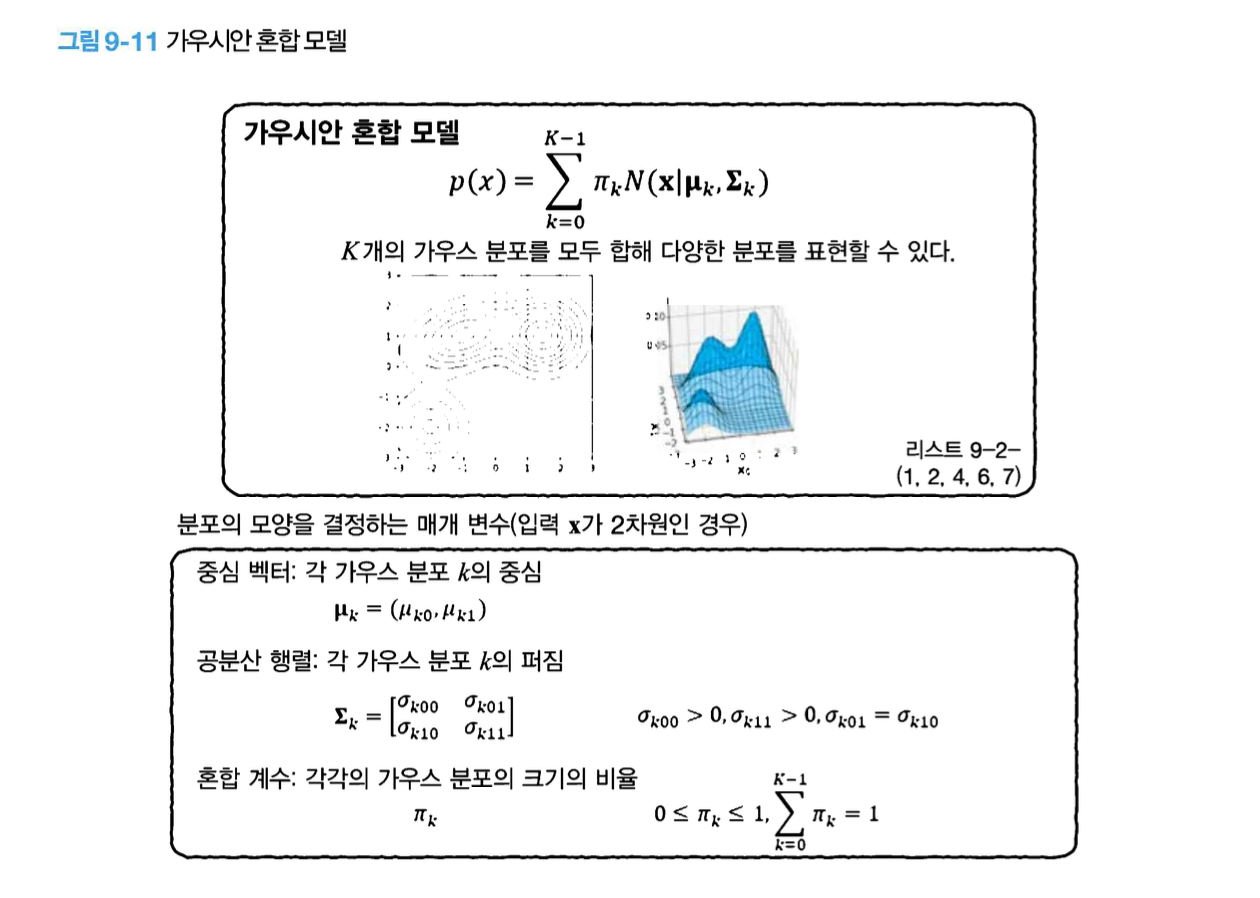

**가우시안 혼합 모델** 2차원 가우스 함수 여러 개를 합친 것

- 혼합 계수: 0과 1 사이의 실수, K로 합을 취하면 1이 되어야 함

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import numpy as np
wk = np.load('data_ch9.npz')
X = wk['X']
X_range0 = wk['X_range0']
X_range1 = wk['X_range1']

In [ ]:
# 가우스 함수 -------------------
def gauss(x, mu, sigma):
    N, D = x.shape
    c1 = 1 / (2 * np.pi) ** (D/2)
    c2 = 1 / (np.linalg.det(sigma) ** (1/2))
    inv_sigma = np.linalg.inv(sigma)
    c3 = x - mu
    c4 = np.dot(c3, inv_sigma)
    c5 = np.zeros(N)
    for d in range(D):
        c5 = c5 + c4[:, d] * c3[:, d]
    p = c1 * c2 * np.exp(-c5 / 2)
    return p

In [ ]:
x = np.array([[1, 2], [2, 1], [3, 4]]) ### N*D 데이터 행렬
mu = np.array([1, 2]) ### 길이 D인 중심 벡터
sigma = np.array([[1, 0], [0, 1]]) ### D*D 공분산 행렬
print(gauss(x, mu, sigma))

[0.15915494 0.05854983 0.00291502]


In [ ]:
# 가우시안 혼합 모델 ----------------
def mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    p = np.zeros(N)
    for k in range(K):
        p = p + pi[k] * gauss(x, mu[k, :], sigma[k, :, :])
    return p

In [ ]:
# test ---------------------------
x = np.array([[1, 2], [2, 2], [3, 4]])
pi = np.array([0.3, 0.7]) ### 혼합 계수 pi: 길이 K의 벡터
mu = np.array([[1, 1], [2, 2]]) # 중심 벡터: K개의 가우스 함수의 중심을 한 번에 지정
sigma = np.array([[[1, 0], [0, 1]], [[2, 0], [0, 1]]]) # 공분산 행렬
print(mixgauss(x, pi, mu, sigma))

[0.09031182 0.09634263 0.00837489]


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# 혼합 가우스 등고선 표시 -----------------
def show_contour_mixgauss(pi, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, (xn*xn, 1)), np.reshape(xx1, (xn*xn, 1))]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    plt.contour(x0, x1, f, 10, colors='gray')

# 혼합 가우스 3D 표시 ------------------
def show3d_mixgauss(ax, pu, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, (xn*xn, 1)), np.reshape(xx1, (xn*xn, 1))]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, rstride=2, cstride=2, alpha=0.3,
                    color='blue', edgecolor='black')

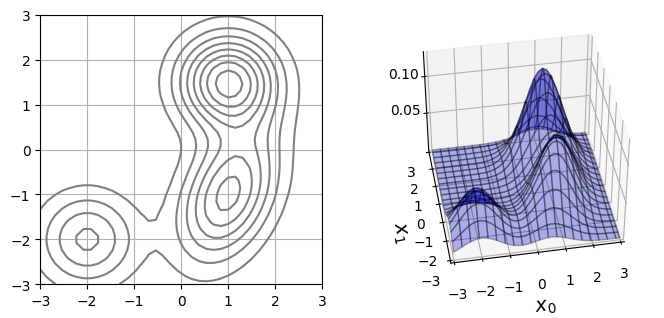

In [ ]:
# test --------------------------------
pi = np.array([0.2, 0.4, 0.4])
mu = np.array([[-2, -2], [-1, 1], [1.5, 1]])
sigma = np.array(
    [[[.5, 0], [0, .5]], [[1, 0.25], [0.25, .5]], [[.5, 0], [0, .5]]])

Fig = plt.figure(1, figsize=(8, 3.5))
Fig.add_subplot(1, 2, 1)
show_contour_mixgauss(pi, mu, sigma)
plt.grid(True)

Ax = Fig.add_subplot(1, 2, 2, projection='3d')
show3d_mixgauss(Ax, pi, mu, sigma)
Ax.set_zticks([0.05, 0.10])
Ax.set_xlabel('$x_0$', fontsize=14)
Ax.set_ylabel('$x_1$', fontsize=14)
Ax.view_init(40, -100)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

###9.3.3 EM 알고리즘의 개요
**EM 알고리즘** 알고리즘 기댓값 최대화 알고리즘, 관측되지 않는 잠재변수에 의존하는 확률 모델에서 최대 가능도나 최대 사후확률을 갖는 모수의 추정값을 찾는 반복적인 알고리즘

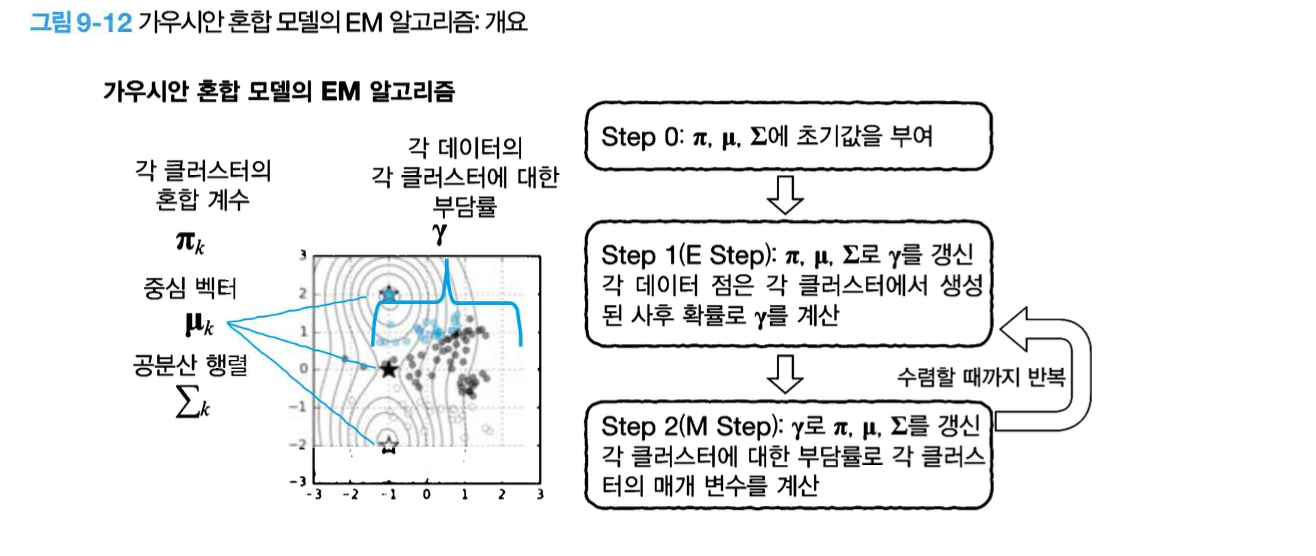

- k-means 기법
    - 각 클러스터를 중심 벡터 μ로 특정
    - 클러스터링의 출력: 1-of-K 부호화에서의 R
- 가우시안 혼합 모델
    - 중심 벡터 μ뿐만 아니라 공분산 행렬 Σ에 의해 각 클러스터의 확산 정도를 기술
    - 혼합 계수 π에 의해 각 클러스터의 크기 차이를 설명
    - 클러스터링의 출력: 각 클래스에 속할 확률에 대응하는 부담률 γ

1. step 0에서 π, μ, Σ 초기화로 시작
2. step 1에서는 현 시점의 π, μ, Σ를 사용하여 γ를 구함 (EM 알고리즘의 E step에 해당, Expectation step)
3. step 2에서는 현 시점의 γ를 사용하여 π, μ, Σ를 구함 (EM 알고리즘의 M step에 해당, Maximazation step)

→ EM 알고리즘은 E step과 M step을 매개 변수가 수렴할 때까지 반복

### 9.3.4 Step 0: 변수의 준비 및 초기화

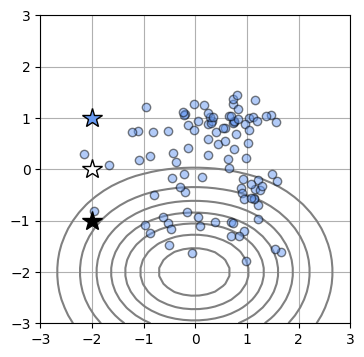

In [ ]:
# 초기 설정 -------------------
N = X.shape[0]
K = 3
Pi = np.array([0.33, 0.33, 0.34])
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]

X_col = np.array([[0.4, 0.6, 0.95], [1, 1, 1], [0, 0, 0]])


# 데이터를 그리기 ----------------
def show_mixgauss_prm(x, gamma, pi, mu, sigma):
    N, D = x.shape
    show_contour_mixgauss(pi, mu, sigma)
    for n in range(N):
        col = gamma[n, 0]*X_col[0] + gamma[n, 1]*X_col[1] + gamma[n, 2]*X_col[2]
        plt.plot(x[n, 0], x[n, 1], 'o',
                 color=tuple(col), markeredgecolor='black',
                 markersize=6, alpha=0.5)
    for k in range(K):
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=tuple(X_col[k]), markersize=15,
                 markeredgecolor='k', markeredgewidth=1)

    plt.grid(True)

plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

### 9.3.5 Step 1(E Step): γ 갱신

γnk: 가우스 함수의 값이 높을수록 부담률도 높아진다는 직관적인 갱신 방법

In [ ]:
# gamma 갱신 (E Step) ----------------
def e_step_mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # K*N
    gamma = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = pi[k] * y[n, k]
        gamma[n, :] = wk / np.sum(wk)
    return gamma


# 메인 --------------------------------
Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)

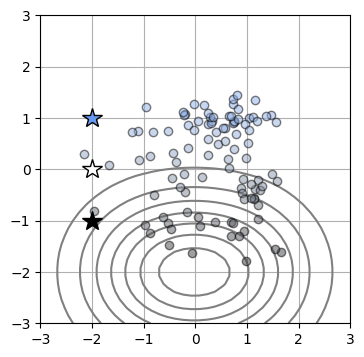

In [ ]:
# 표시 ---------------------------------
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

### 9.3.6 Step 2(M Step): π, μ, Σ의 갱신

- Nk: 각 클러스터에 대한 부담률의 합 (K-means 기법의 각 클러스터에 속할 데이터 수와 대응)
- πk: 혼합률, 전체에 대한 클러스터 내 수의 비율
- μk: 중심 벡터, 클러스터에 부담률의 가중치를 더한 데이터의 평균(K-means 기법의 클러스터 데이터의 평균을 구하는 step 2에 대응)
- 가우스 공분산 행렬 갱신 (위에서 구한 새로운 중심벡터를 사용)

In [ ]:
# Pi, Mu, Sigma 갱신 (M step) ----------
def m_step_mixgauss(x, gamma):
    N, D = x.shape
    N, K = gamma.shape
    # pi를 계산
    pi = np.sum(gamma, axis=0) / N
    # mu을 계산
    mu = np.zeros((K, D))
    for k in range(K):
        for d in range(D):
            mu[k, d] = np.dot(gamma[:, k], x[:, d]) / np.sum(gamma[:, k])
    # sigma를 계산
    sigma = np.zeros((K, D, D))
    for k in range(K):
        for n in range(N):
            wk = x - mu[k, :]
            wk = wk[n, :, np.newaxis]
            sigma[k, :, :] = sigma[k, :, :] + gamma[n, k] * np.dot(wk, wk.T)
        sigma[k, :, :] = sigma[k, :, :] / np.sum(gamma[:, k])
    return pi, mu, sigma


# 메인 ---------------------------------
Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

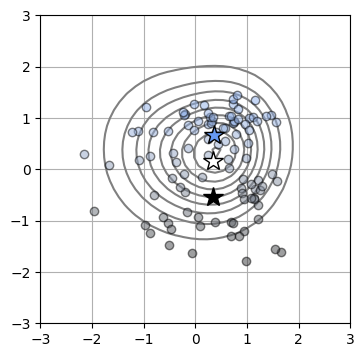

In [ ]:
# 표시 ----------------------------------
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

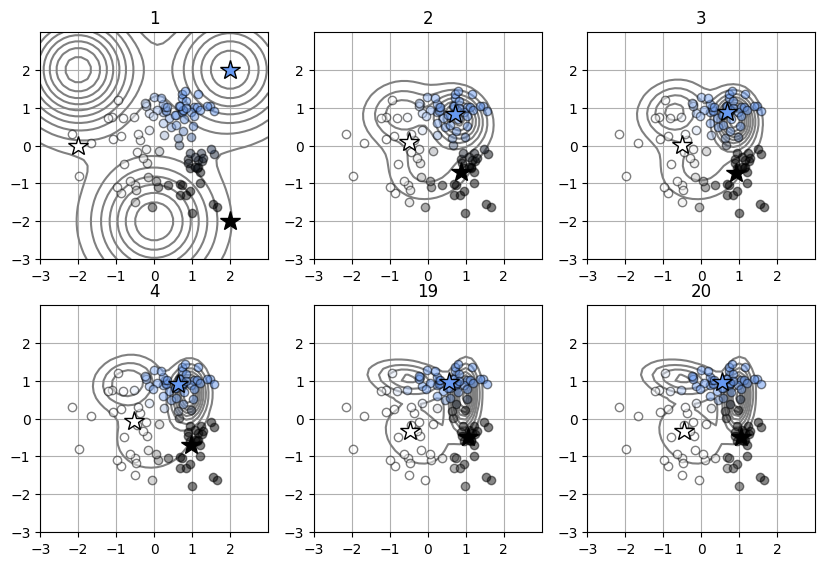

In [ ]:
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
plt.figure(1, figsize=(10, 6.5))
max_it = 20 # 반복 횟수

i_subplot = 1;
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    if it<4 or it>17:
        plt.subplot(2, 3, i_subplot)
        show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
        plt.title('{0:d}'.format(it+1))
        plt.xticks(range(X_range0[0], X_range0[1]))
        plt.yticks(range(X_range1[0], X_range1[1]))
        i_subplot = i_subplot+1
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)
plt.show()

- 3개의 가우스 함수는 각 클러스터의 중심으로 이동해 수렴
- 각 데이터 점에서 각 클러스터의 부담률은 그라데이션으로 나타남

→ 클러스터링 결과 또한 매개 변수의 초기값에 따라 달라짐 </br>

- 클러스터링의 장점을 평가하기 위해
    - K-means 기법: 왜곡 척도 사용
    - 가우시안 혼합 모델: 가능도 사용

    AFTER: K-means는 거리 기반의 왜곡 척도를 사용하기 때문에 데이터 분포 형태에 따라 잘못된 분류가 일어날 수 있음

### 9.3.7 가능도

앞선 EM 알고리즘에서, 입력 데이터 X는 가우시안 혼합 모델에서 생성된 것으로 생각하여, X가 생성된 확률(가능도)이 가장 높도록 매개변수가 갱신되고 있었음 → **가능도 극대화의 원리**

In [ ]:
# 혼합 가우스의 목적 함수 --------
def nlh_mixgauss(x, pi, mu, sigma):
    # x: N*D
    # pi: K*1
    # mu: K*D
    # sigma: K*D*D
    # output 1h: N*K
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # K*N
    lh = 0
    for n in range(N):
        wk = 0
        for k in range(K):
            wk = wk + pi[k] * y[n, k]
        lh = lh + np.log(wk)
    return -lh

[426.22 229.86 224.32 220.8  218.63 216.93 215.93 215.51 215.33 215.24
 215.18 215.15 215.13 215.11 215.1  215.1  215.09 215.09 215.08 215.08]


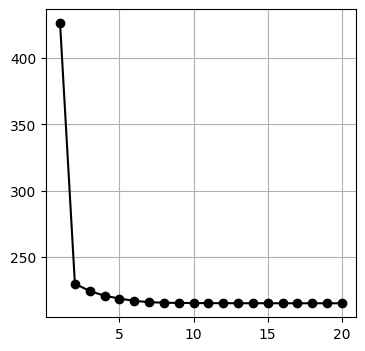

In [ ]:
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]


max_it = 20
it = 0
Err = np.zeros(max_it) # distortion measure
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    Err[it] = nlh_mixgauss(X, Pi, Mu, Sigma)
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)


print(np.round(Err, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(np.arange(max_it) + 1,
         Err, color='k', linestyle='-', marker='o')
# plt.ylim([40, 80])
plt.grid(True)
plt.show()

음의 로그 가능도는 점차 감소해 step 10 정도에서 거의 수렴